# 9.1. 감정 분석 모델 만들기

## 9.1.3. 데이터 불러오기

In [1]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

root = '/content/drive/MyDrive/TNT/산업인공지능/교재/CH9/Ch2.Emotion/kaggle/'
label = 'train.csv'

In [2]:
df = pd.read_csv(os.path.join(root, label))
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [3]:
df.pixels.shape

(28709,)

In [4]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

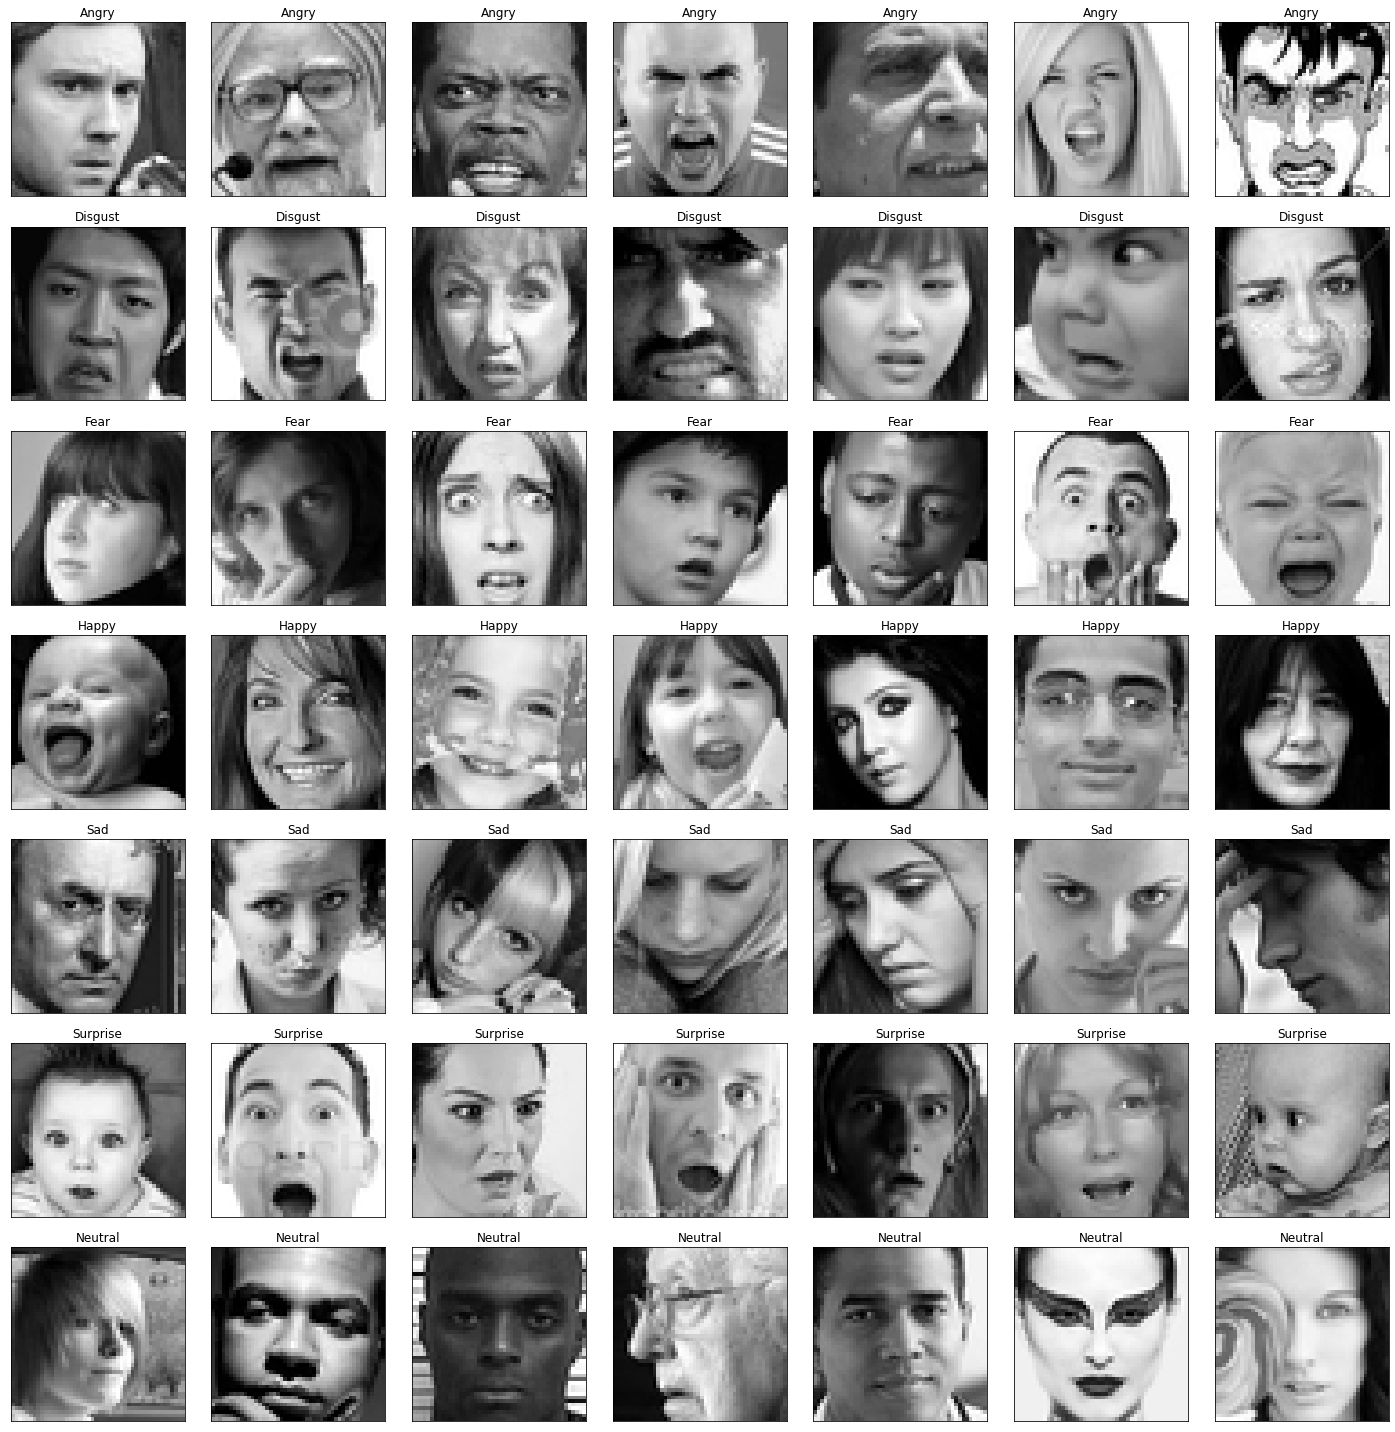

In [5]:
fig = plt.figure(1, (20, 20))

k = 0
for label in sorted(df['emotion'].unique()):
    for j in range(7):
        px = df[df['emotion']==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions[label])
        plt.tight_layout()

In [6]:
x = []

for px in df.pixels:
  temp = np.array(px.split(' ')).reshape(48, 48).astype('float32')
  x.append(temp)

In [7]:
x = np.reshape(np.array(x)/255, (-1, 48, 48, 1))
y = np.array(df.emotion)

In [8]:
print(x.shape)
print(y.shape)

(28709, 48, 48, 1)
(28709,)


In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 20)

In [10]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(np.reshape(list(y_train), (-1, 1)))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [11]:
y_train_hot = enc.transform(np.reshape(list(y_train), (-1, 1))).toarray()
y_test_hot = enc.transform(np.reshape(list(y_test), (-1, 1))).toarray()

In [12]:
y_train_hot[0]

array([0., 0., 1., 0., 0., 0., 0.])

## 9.1.4. 데이터 학습하기

In [13]:
import tensorflow as tf

im_size = 48

model = tf.keras.models.Sequential([
  tf.keras.layers.Input((im_size, im_size, 1), dtype=tf.float32),

  # 첫 번째 은닉층
  tf.keras.layers.Conv2D(6, (5, 5), activation='relu' ,padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  # 두 번째 은닉층
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(294, activation='relu'),
  tf.keras.layers.Dense(7, activation='softmax')
])

# 모델 생성
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer= opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 6)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3456)              0         
_________________________________________________________________
dense (Dense)                (None, 294)               1016358   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 2065      
Total params: 1,018,579
Trainable params: 1,018,579
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 학습
history  = model.fit(x_train, y_train_hot, epochs=20, validation_data=(x_test, y_test_hot))

Epoch 1/20
718/718 [==============================] - 38s 51ms/step - loss: 1.7206 - accuracy: 0.3173 - val_loss: 1.6446 - val_accuracy: 0.3741
Epoch 2/20
718/718 [==============================] - 37s 51ms/step - loss: 1.5761 - accuracy: 0.3975 - val_loss: 1.5670 - val_accuracy: 0.4070
Epoch 3/20
718/718 [==============================] - 37s 51ms/step - loss: 1.5123 - accuracy: 0.4256 - val_loss: 1.5518 - val_accuracy: 0.4070
Epoch 4/20
718/718 [==============================] - 37s 51ms/step - loss: 1.4722 - accuracy: 0.4409 - val_loss: 1.5230 - val_accuracy: 0.4194
Epoch 5/20
718/718 [==============================] - 37s 52ms/step - loss: 1.4393 - accuracy: 0.4543 - val_loss: 1.5044 - val_accuracy: 0.4317
Epoch 6/20
718/718 [==============================] - 37s 51ms/step - loss: 1.4105 - accuracy: 0.4648 - val_loss: 1.4859 - val_accuracy: 0.4450
Epoch 7/20
718/718 [==============================] - 37s 51ms/step - loss: 1.3819 - accuracy: 0.4818 - val_loss: 1.4863 - val_accuracy:

In [15]:
from sklearn.metrics import accuracy_score

print('Accuracy: {:.2%}'.format(accuracy_score(y_test, np.argmax(model.predict(x_test), axis = -1))))

Accuracy: 47.00%


6.24%		Angry
1.32%		Disgust
15.91%		Fear
11.15%		Happy
23.33%		Sad
0.38%		Surprise
41.67%		Neutral
y_test :  6


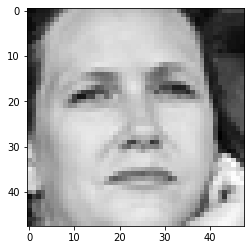

In [16]:
idx = 0
imageToUse = np.reshape(x_test[idx], (-1, im_size, im_size, 1))
plt.imshow(np.reshape(imageToUse,(im_size,im_size)), interpolation='nearest', cmap='gray')

predict = model.predict(imageToUse)[0]

temp = 0
for i in predict:
    print('{:.2%}\t\t{}'.format(i, emotions[temp]))
    temp += 1

print("y_test : ", y_test[idx])

# 9.2. XAI 결합하기

In [17]:
from keras import backend as K
weights = model.get_weights()

# 활성화 결괏값
activations = []
for layer in model.layers:
    keras_function = K.function([model.input], [layer.output])
    activations.append(keras_function(imageToUse))

Activations =[]
Activations.append(activations[0][0])   # (1, 48, 48, 6)
Activations.append(activations[1][0])   # (1, 24, 24, 6)
#Activations.append(activations[2][0])  # (1, 3456)  # activations[1][0]과 동일, 형태만 다름
Activations.append(activations[3][0])   # (1, 294)
#Activations.append(activations[4][0])  # (1, 7) # LRP에 사용안함

# 가중치
w = []
w.append
w.append(weights[0]) # (5, 5, 1, 6)
w.append(weights[2]) # (3456, 294)
w.append(weights[4]) # (294, 7)

# 편향
biases = []
biases.append(weights[1]) # (6,)
biases.append(weights[3]) # (294,)
biases.append(weights[5]) # (7,)

In [18]:
from tensorflow.python.ops import gen_nn_ops

def backprop_dense(activation, weight, bias, relevance):
    w = tf.maximum(0., weight)
    b = tf.maximum(0., bias)
    z = tf.matmul(activation, w) + b
    
    s = relevance / z
    c = tf.matmul(s, tf.transpose(w))
    return activation * c

def backprop_pooling(activation, relevance):
    # kernel size, strides
    # if z is zero
    ksize = strides = [1, 2, 2, 1]
    z = tf.nn.max_pool(activation, ksize, strides, padding='SAME') + 1e-10
    s = relevance / z
    # input, argmax, argmax_mask
    c = gen_nn_ops.max_pool_grad(activation, z, s, ksize, strides, padding='SAME')
    return activation * c

def backprop_conv(activation, weight, bias, relevance):
    strides = [1, 1, 1, 1]
    w = tf.maximum(0., weight)
    b = tf.maximum(0., bias)
    z = tf.nn.conv2d(activation, w, strides, padding='SAME')
    z = tf.nn.bias_add(z, b)
    s = relevance / z
    c = tf.compat.v1.nn.conv2d_backprop_input(tf.shape(activation), w, s, strides, padding='SAME')
    return activation * c

## Get $f_x$

In [19]:
f_x = max(predict)
print(f_x)

0.4166625


## Get $R3 \leftarrow f_x$

In [20]:
predict[predict < 0] = 0
R3 = predict
R3.shape

(7,)

## Get $R2 \leftarrow R3 \leftarrow f_x$

In [21]:
a = Activations.pop() # (1, 294)
ws = w.pop()  # (294, 7)
b = biases.pop() # (7,)

print(a.shape)
print(ws.shape)

R2 = backprop_dense(a.reshape(1, 294), ws, b, R3)

print(R2.shape)

(1, 294)
(294, 7)
(1, 294)


## Get $R1 \leftarrow R2 \leftarrow R3 \leftarrow f_x$

In [22]:
a = Activations.pop() # (1, 24, 24, 6)
ws = w.pop() # (3456, 294)
b = biases.pop() # (294,)
print(a.shape)
print(ws.shape)

# 3456 = 24 * 24 * 6
R1 = backprop_dense(a.reshape(1, 3456), ws, b, R2)

print(R1.shape)

(1, 24, 24, 6)
(3456, 294)
(1, 3456)


## Get $R0 \leftarrow R1 \leftarrow R2 \leftarrow R3 \leftarrow f_x$

In [23]:
a = Activations.pop() # (1, 48, 48, 6) # pooling
ws = w.pop() # (5, 5, 1, 6)
b = biases.pop() # (6,)

print(a.shape)
print(ws.shape)
print(b.shape)

# max pool
R_p = backprop_pooling(a, tf.reshape(R1, (1, 24, 24, 6)))

# convolution
R0 = backprop_conv(imageToUse, ws, b, R_p)

# LRP out
LRP_out = R0
print(LRP_out.shape)

(1, 48, 48, 6)
(5, 5, 1, 6)
(6,)
(1, 48, 48, 1)


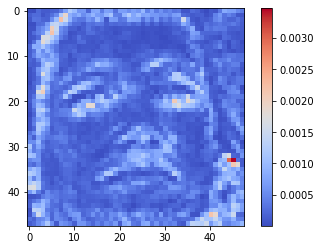

In [24]:
plt.imshow(np.reshape(LRP_out, (48, 48)), interpolation="nearest", cmap=plt.cm.coolwarm)
plt.colorbar(orientation='vertical')

In [25]:
def getLRP(img):
    imageToUse = np.reshape(img, (-1, 48, 48, 1))
    predict = model.predict(imageToUse)[0]

    activations = []
    for layer in model.layers:
        keras_function = K.function([model.input], [layer.output])
        activations.append(keras_function(imageToUse))

    Activations =[]
    Activations.append(activations[0][0]) # (1, 48, 48, 6)
    Activations.append(activations[1][0]) # (1, 24, 24, 6)
    #Activations.append(activations[2][0]) # (1, 3456)  # activations[1][0]과 동일, 형태만 다름
    Activations.append(activations[3][0]) # (1, 294)
    #Activations.append(activations[4][0]) # (1, 7) # LRP에 사용안함

    weights = model.get_weights()
    
    # 가중치
    w = []
    w.append
    w.append(weights[0]) # (5, 5, 1, 6)
    w.append(weights[2]) # (3456, 294)
    w.append(weights[4]) # (294, 7)

    # 편향
    biases = []
    biases.append(weights[1]) # (6,)
    biases.append(weights[3]) # (294,)
    biases.append(weights[5]) # (7,)
        
    # get f_x
    f_x = max(predict)
    
    # R3
    predict[predict < 0] = 0
    R3 = predict
    
    # R2
    a = Activations.pop()
    ws = w.pop()
    b = biases.pop()
    R2 = backprop_dense(a.reshape(1, 294), ws, b, R3)
    
    # R1
    a = Activations.pop()
    ws = w.pop()
    b = biases.pop()

    # 3456 = 24 * 24 * 6
    R1 = backprop_dense(a.reshape(1, 3456), ws, b, R2)
    
    # R0
    # max pool
    a = Activations.pop()
    R_p = backprop_pooling(a, tf.reshape(R1, (1, 24, 24, 6)))

    # convolution
    ws = w.pop()
    b = biases.pop()
    R0 = backprop_conv(imageToUse, ws, b, R_p)
    
    # LRP_out
    LRP_out = R0

    return LRP_out

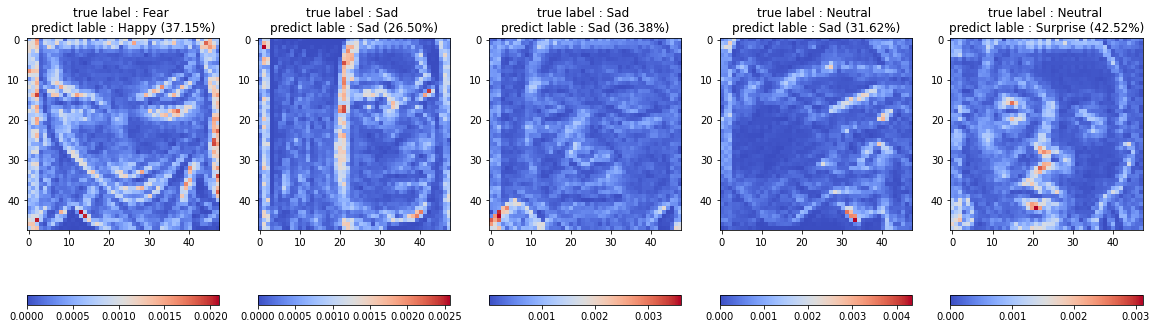

In [26]:
temp = x_test[5:10]
true_label = y_test[5:10]

plt.figure(figsize=(20, 8))

for i in range(len(temp)):
    plt.subplot(1, 5, i + 1)

    imageToUse = np.reshape(temp[i], (-1, 48, 48, 1))
    predict = model.predict(imageToUse)[0]

    plt.title('true label : {} \npredict lable : {} ({:.2%})'.format(emotions[true_label[i]], emotions[np.argmax(predict)], np.max(predict)))
    plt.imshow(np.reshape(getLRP(imageToUse), (48, 48)), interpolation="nearest", cmap=plt.cm.coolwarm)
    plt.colorbar(orientation='horizontal')

# 9.3. XAI로 원래 인공지능 개선하기



In [32]:
import tensorflow as tf

im_size = 48

model = tf.keras.models.Sequential([
  tf.keras.layers.Input((im_size, im_size, 1), dtype=tf.float32),

  # 첫 번째 은닉층
  tf.keras.layers.Conv2D(6, (5, 5), activation='relu' ,padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  # 두 번째 은닉층
  tf.keras.layers.Conv2D(16, (5, 5), activation='relu' ,padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  # 세 번째 은닉층
  tf.keras.layers.Conv2D(120, (5, 5), activation='relu' ,padding='same'),

  # 네 번째 은닉층
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(294, activation='relu'),
  tf.keras.layers.Dense(7, activation='softmax')
])

# 모델 생성
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer= opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 6)         156       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 16)        2416      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 120)       48120     
_________________________________________________________________
flatten_2 (Flatten)          (None, 17280)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 294)              

In [33]:
# 학습
history  = model.fit(x_train, y_train_hot, epochs=20, validation_data=(x_test, y_test_hot))

Epoch 1/20
718/718 [==============================] - 108s 150ms/step - loss: 1.6970 - accuracy: 0.3290 - val_loss: 1.6011 - val_accuracy: 0.3910
Epoch 2/20
718/718 [==============================] - 108s 151ms/step - loss: 1.5434 - accuracy: 0.4108 - val_loss: 1.5253 - val_accuracy: 0.4209
Epoch 3/20
718/718 [==============================] - 108s 150ms/step - loss: 1.4671 - accuracy: 0.4446 - val_loss: 1.4911 - val_accuracy: 0.4274
Epoch 4/20
718/718 [==============================] - 108s 150ms/step - loss: 1.4088 - accuracy: 0.4626 - val_loss: 1.4463 - val_accuracy: 0.4525
Epoch 5/20
718/718 [==============================] - 108s 150ms/step - loss: 1.3554 - accuracy: 0.4861 - val_loss: 1.4116 - val_accuracy: 0.4652
Epoch 6/20
718/718 [==============================] - 108s 150ms/step - loss: 1.3031 - accuracy: 0.5084 - val_loss: 1.3868 - val_accuracy: 0.4746
Epoch 7/20
718/718 [==============================] - 108s 151ms/step - loss: 1.2531 - accuracy: 0.5298 - val_loss: 1.3817 -

In [34]:
from sklearn.metrics import accuracy_score

print('Accuracy: {:.2%}'.format(accuracy_score(y_test, np.argmax(model.predict(x_test), axis = -1))))

Accuracy: 48.47%


In [35]:
def getLRP(img):
    imageToUse = np.reshape(img, (-1, 48, 48, 1))
    predict = model.predict(imageToUse)[0]

    activations = []
    for layer in model.layers:
        keras_function = K.function([model.input], [layer.output])
        activations.append(keras_function(imageToUse))

    Activations =[]
    Activations.append(activations[0][0])     # (1, 48, 48, 6)    conv2d_4 *
    Activations.append(activations[1][0])     # (1, 24, 24, 6)    max_pooling2d_3
    Activations.append(activations[2][0])     # (1, 24, 24, 16)   conv2d_5 *
    Activations.append(activations[3][0])     # (1, 12, 12, 16)   max_pooling2d_4
    Activations.append(activations[4][0])     # (1, 12, 12, 120)  conv2d_6 *
    #Activations.append(activations[5][0])    # (1, 17280)        flatten_2
    Activations.append(activations[6][0])     # (1, 294)          dense_4 *
    #Activations.append(activations[7][0])    # (1, 7)            dense_5 *

    weights = model.get_weights()
    
    # 가중치
    w = []
    w.append
    w.append(weights[0]) # (5, 5, 1, 6)
    w.append(weights[2]) # (5, 5, 6, 16)
    w.append(weights[4]) # (5, 5, 16, 120)
    w.append(weights[6]) # (17280, 294)
    w.append(weights[8]) # (294, 7)

    # 편향
    biases = []
    biases.append(weights[1]) # (6,)
    biases.append(weights[3]) # (16,)
    biases.append(weights[5]) # (120,)
    biases.append(weights[7]) # (294,)
    biases.append(weights[9]) # (7,)
        
    # get f_x
    f_x = max(predict)
    
    # R5
    predict[predict < 0] = 0
    R5 = predict
    
    # R4  # dense_5 *
    a = Activations.pop()
    ws = w.pop()
    b = biases.pop()
    R4 = backprop_dense(a, ws, b, R5)

    # R3  # dense_4 *
    a = Activations.pop()
    ws = w.pop()
    b = biases.pop()
    R3 = backprop_dense(a.reshape(1, 17280), ws, b, R4)
    
    # R2  # flatten_2 + conv2d_6 *
    a = Activations.pop()
    ws = w.pop()
    b = biases.pop()
    R2 = backprop_conv(a, ws, b, tf.reshape(R3, (1, 12, 12, 120)))

    # R1  # max_pooling2d_4 + conv2d_5 *
    ## max pool
    a = Activations.pop()
    R_p = backprop_pooling(a, R2)

    ## convolution
    a = Activations.pop()
    ws = w.pop()
    b = biases.pop()
    R1 = backprop_conv(a, ws, b, R_p)

    # R0  # max_pooling2d_3 + conv2d_4 *
    ## max pool
    a = Activations.pop()
    R_p = backprop_pooling(a, R1)

    ## convolution
    ws = w.pop()
    b = biases.pop()
    R0 = backprop_conv(imageToUse, ws, b, R_p)
    
    # LRP_out
    LRP_out = R0

    return LRP_out

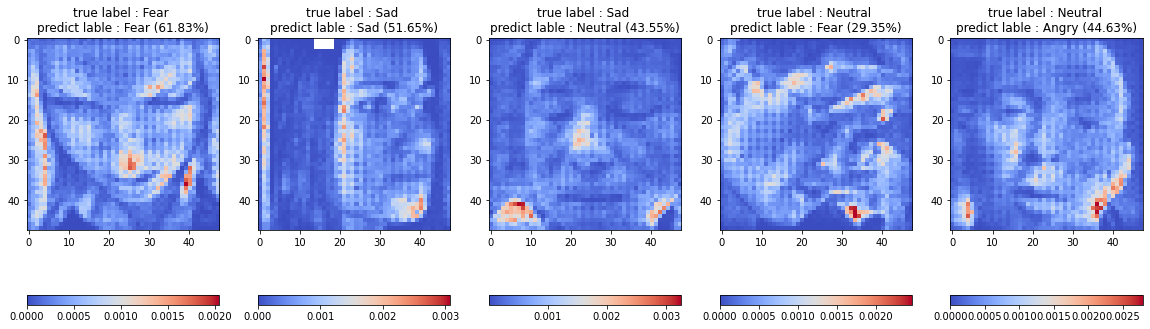

In [36]:
temp = x_test[5:10]
true_label = y_test[5:10]

plt.figure(figsize=(20, 8))

for i in range(len(temp)):
    plt.subplot(1, 5, i + 1)

    imageToUse = np.reshape(temp[i], (-1, 48, 48, 1))
    predict = model.predict(imageToUse)[0]

    plt.title('true label : {} \npredict lable : {} ({:.2%})'.format(emotions[true_label[i]], emotions[np.argmax(predict)], np.max(predict)))
    plt.imshow(np.reshape(getLRP(imageToUse), (48, 48)), interpolation="nearest", cmap=plt.cm.coolwarm)
    plt.colorbar(orientation='horizontal')